In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

%matplotlib inline

In [2]:
os.chdir(r'C:\Users\alanw\OneDrive\Varsity\Research\Code')

In [3]:
# Loading  data
def import_data(type):
    if type == "Balanced":
        df = pd.read_csv('data_balanced_cv.csv')
    elif type == "Original":
        df = pd.read_csv('data_not_cleaned.csv')
    return df

In [4]:
df = import_data("Balanced")

# Data Prep

Scaling Data

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
scaler = StandardScaler()

In [7]:
scaler.fit(df.drop('Y',axis=1))

StandardScaler()

In [8]:
scaled_features = scaler.fit_transform(df.drop('Y',axis=1))

Splitting labels and features

In [9]:
X = pd.DataFrame(scaled_features,columns=df.columns[:-1]).values
y = df['Y'].values

In [10]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=69)

In [11]:
x, z = df['Y'].value_counts()
print("Data Split: " + str(int(x/(x+z)*100)) + ":" + str(int(z/(x+z)*100)))

Data Split: 52:47


# Setting Up and Training The Model

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
logmodel = LogisticRegression()

# Gridsearch 

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# define search space
param_grid = dict()
param_grid['penalty'] = ['l1', 'l2', 'elasticnet']
param_grid['C'] = [0.1, 1, 10, 100]

In [16]:
# define search
grid = GridSearchCV(logmodel, param_grid, scoring='accuracy', n_jobs=-1, cv=5)

In [17]:
t0 = datetime.now()
grid_results = grid.fit(X, y)
t1 = datetime.now()

In [18]:
# summarize results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
print("Execution Time: ", (t1 - t0))

Best: 0.705531 using {'C': 0.1, 'penalty': 'l2'}
Execution Time:  0:00:07.274958


# Crossvalidate Best Model

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

In [20]:
best_logmodel = LogisticRegression(C=grid_results.best_params_['C'],
                                   penalty=grid_results.best_params_['penalty'])

In [21]:
t0 = datetime.now()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)
scores = cross_validate(best_logmodel, X, y, scoring=['accuracy','roc_auc','precision','recall','f1'], cv=cv, n_jobs=-1)
t1 = datetime.now()

In [22]:
print('Mean Accuracy: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_accuracy']*100), np.std(scores['test_accuracy']*100)))
print('Mean ROC AUC: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_roc_auc']*100), np.std(scores['test_roc_auc']*100)))
print('Mean Precision: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_precision']*100), np.std(scores['test_precision']*100)))
print('Mean Recall: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_recall']*100), np.std(scores['test_recall']*100)))
print('Mean F1 Score: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_f1']*100), np.std(scores['test_f1']*100)))
print("Execution Time: ", (t1 - t0))

Mean Accuracy: 70.49% Std Dev: (+/- 0.781%)
Mean ROC AUC: 76.09% Std Dev: (+/- 0.750%)
Mean Precision: 70.37% Std Dev: (+/- 0.950%)
Mean Recall: 65.55% Std Dev: (+/- 1.371%)
Mean F1 Score: 67.87% Std Dev: (+/- 0.946%)
Execution Time:  0:00:02.147436


### Final Evaluations

In [23]:
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score, plot_roc_curve, classification_report
import pickle
import shap

In [24]:
t0 = datetime.now()
best_logmodel.fit(X,y)
t1 = datetime.now()
print("Training Time: ", (t1 - t0))

Training Time:  0:00:00.220761


In [37]:
shap_values = shap.LinearExplainer(best_logmodel,X).shap_values(X)

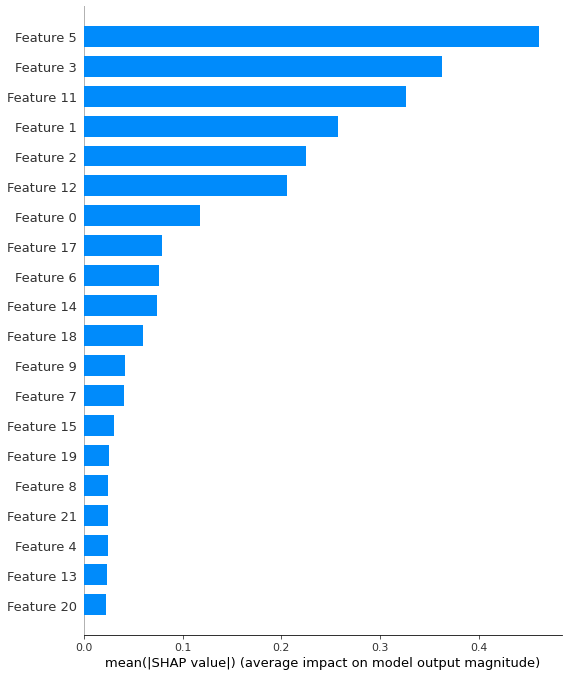

In [44]:
plt.figure(figsize=(7, 5))
ax = shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\logit_shap.png')
plt.show()

In [39]:
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score, plot_roc_curve, classification_report

In [40]:
predictions = best_logmodel.predict(X_test)

<Figure size 504x360 with 0 Axes>

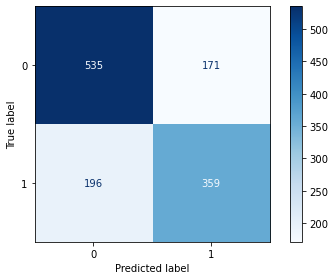

In [41]:
plt.figure(figsize=(7, 5))
ax = plot_confusion_matrix(best_logmodel,X_test,y_test,cmap=plt.cm.Blues)

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\logit_conf.png')
plt.show()


<Figure size 504x360 with 0 Axes>

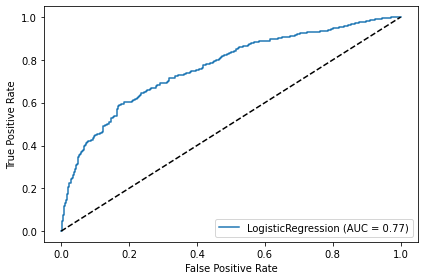

In [42]:
plt.figure(figsize=(7, 5))
ax = plot_roc_curve(best_logmodel,X_test,y_test)
x = np.linspace(0, 1, 100)
ax = plt.plot(x, x, linestyle='--',color='black')

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\logit_roc.png')
plt.show()

In [30]:
kappa = cohen_kappa_score(y_test, predictions)
print("Cohen's Kappa: %.2f" % (kappa))

Cohen's Kappa: 0.41


In [31]:
import pickle

In [32]:
Pkl_Filename = "Logit_Final.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_logmodel, file)

In [33]:
import dill
dill.dump_session('logit_final.db')

In [34]:
import dill
dill.load_session(r'C:\Users\alanw\OneDrive\Varsity\Research\Code\logit_final.db')